In [1]:
import json
import csv
import tweepy
import re
import io
import spacy
import numpy as np
import pandas as pd

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords  
from nltk.corpus import twitter_samples
import pickle
import nltk
nltk.download('twitter_samples')

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/imad/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


# 1. Consommer une A.P.I. issue d'un réseau sociale pour créer un Dataset 

In [2]:
key = '9MEKTohHO9znsDTCEK0etpWJO'
secret = 'wmouBMmW654E6d35xi5vcEKFk22czU8aKl72sHK6VFbfI8TK8G'
token = '1437692687021481985-2tNIyf0RoYvjrabwy13jurkpJoQ1Fr'
token_secret = 'dJGozBqPtPun0TXw9KqlQBYYTgqNfkAsfBjvKHOPaGeUK'

In [3]:
auth = tweepy.OAuthHandler(key,secret)
auth.set_access_token(token,token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [4]:
# Name of csv file to be created
fname = "dataset"
hashtag_phrase= "@TRUMP"

# Open the spreadsheet
with open('%s.csv' % (fname), 'w', encoding="utf-8") as file:
    w = csv.writer(file)

    # Write header row (feature column names of your choice)
    w.writerow(['timestamp', 'tweet_text', 'username', 'all_hashtags', 'location', 
                'followers_count', 'retweet_count', 'favorite_count'])

    # For each tweet matching hashtag, write relevant info to the spreadsheet
    for tweet in tweepy.Cursor(api.search, q=hashtag_phrase+' -filter:retweets', lang="en", tweet_mode='extended').items(1000):
        w.writerow([
                    tweet.created_at, 
                    tweet.full_text.replace('\n',' ').encode('utf-8'), 
                    tweet.user.screen_name.encode('utf-8'), 
                    [e['text'] for e in tweet._json['entities']['hashtags']],  
                    tweet.user.location, 
                    tweet.user.followers_count, 
                    tweet.retweet_count, 
                    tweet.favorite_count
                    ])


In [5]:
data = open('dataset.csv') 
df2 = pd.DataFrame(data, columns = ['tweet_text'])
df2

,tweet_text
0,"timestamp,tweet_text,username,all_hashtags,loc..."
1,"2021-09-20 11:30:06,""b""""Each time you tweet, @..."
2,"2021-09-20 10:50:50,""b""""@MaryPatFlynn1 @donwin..."
3,"2021-09-20 10:44:27,""b'@donwinslow @ThugLifeSo..."
4,"2021-09-20 10:24:33,""b'@donwinslow @ThugLifeSo..."
...,...
92,"2021-09-19 13:49:36,b'@Casper324B @DoggyMichae..."
93,"2021-09-19 13:29:21,""b""""Each time you tweet, @..."
94,"2021-09-19 13:07:09,""b""""@DonaldJTrumpJr And ho..."
95,"2021-09-19 12:05:54,b'@Casper324B @dguilford @..."


# 2 . Utiliser du machine Learning (ou du Deep Learning) pour classifier les différents commentaires selon s'ils sont excellent, bon, neutre, mauvais, exécrable

In [6]:
import pandas as pd
df = pd.read_csv('Tweets.csv')
df.head

<bound method NDFrame.head of                  tweet_id airline_sentiment  airline_sentiment_confidence  \
0      570306133677760513           neutral                        1.0000   
1      570301130888122368          positive                        0.3486   
2      570301083672813571           neutral                        0.6837   
3      570301031407624196          negative                        1.0000   
4      570300817074462722          negative                        1.0000   
...                   ...               ...                           ...   
14635  569587686496825344          positive                        0.3487   
14636  569587371693355008          negative                        1.0000   
14637  569587242672398336           neutral                        1.0000   
14638  569587188687634433          negative                        1.0000   
14639  569587140490866689           neutral                        0.6771   

               negativereason  negativereason

In [7]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
reviews = preprocessing.LabelEncoder()

In [8]:
reviews = df.iloc[:, 10].values 
labels = df.iloc[:, 1].values

In [9]:
#X = df.iloc[:, 10].values  
#y = df.iloc[:, 1].values

In [10]:
processed_tweets = []
 
for tweet in range(0, len(reviews)):  
    # Remove all the special characters
    processed_tweet = re.sub(r'\W', ' ', str(reviews[tweet]))
 
    # remove all single characters
    processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
 
    # Remove single characters from the start
    processed_tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_tweet) 
 
    # Substituting multiple spaces with single space
    processed_tweet= re.sub(r'\s+', ' ', processed_tweet, flags=re.I)
 
    # Removing prefixed 'b'
    processed_tweet = re.sub(r'^b\s+', '', processed_tweet)
 
    # Converting to Lowercase
    processed_tweet = processed_tweet.lower()
    processed_tweets.append(processed_tweet)
    
    #Stopwords
    #stop_words = set(stopwords.words('english'))
    #processed_tweet = [w for w in processed_tweet if not w in stop_words]
    #processed_tweets.append(processed_tweet)

In [11]:
#Split data
reviews = processed_tweets
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, random_state=1000)

In [12]:

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(reviews_train)
X_train = vectorizer.transform(reviews_train)
X_test = vectorizer.transform(reviews_test)

In [13]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(max_iter=10000)
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [14]:
accuracy = classifier.score(X_test, y_test)
print('Accuracy:', accuracy)

Accuracy: 0.8084016393442623


In [15]:
new_reviews = ['good excellent happy','sad bad terrible fight','ok neutral chill']
X_new = vectorizer.transform(new_reviews)
classifier.predict(X_new)

array(['positive', 'negative', 'neutral'], dtype=object)

In [16]:
new_reviews = ['I love you my president Trump is the man  And our hope in united states', 'This thread details the extraordinary lengths @Trump  then went to in order to overturn the results of the election whilst pushing the fake Stop the Steal narrative', 'Now they are ramping up the lies, disinformation, crazy, divisive and dangerous rhetoric heading towards']
X_new = vectorizer.transform(new_reviews)
classifier.predict(X_new)

array(['positive', 'negative', 'negative'], dtype=object)

# 3. Pouvoir sauvegarder le modèle et le réutiliser et faire plusieurs versions

In [17]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(classifier, open(filename, 'wb'))

# 4. Faire une courte analyse du modèle et vérifier que le résultat attendu est atteint

In [18]:
y_pred = classifier.predict(X_test)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

    negative       0.87      0.90      0.88      1882
     neutral       0.64      0.62      0.63       600
    positive       0.75      0.69      0.72       446

    accuracy                           0.81      2928
   macro avg       0.75      0.74      0.74      2928
weighted avg       0.81      0.81      0.81      2928



In [19]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['NEGATIVE','NEUTRAL','POSITIVE'], 
                     columns = ['NEGATIVE','NEUTRAL','POSITIVE'],)
cm_df

,NEGATIVE,NEUTRAL,POSITIVE
NEGATIVE,1686,149,47
NEUTRAL,172,372,56
POSITIVE,73,64,309


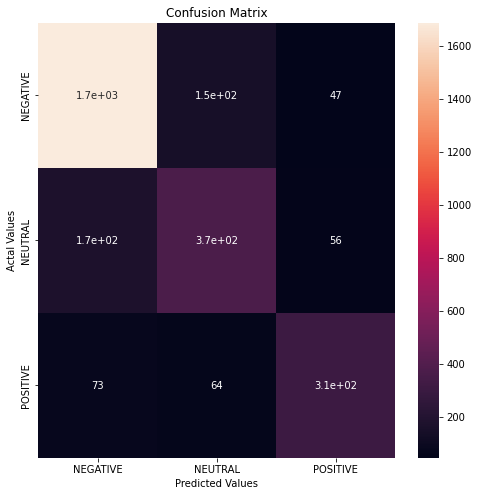

In [20]:
#Plotting the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# Load Model Score 

In [21]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8084016393442623
